<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B31_4%5D_Transfer_Learning_CIFAR_10_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Transfer Learning
Di sini kita akan mencoba melatih VGG16 untuk mengklasifikasikan dataset CIFAR-10

Kema yang akan kita coba antara lain:
* Melatih VGG16 dari awal (bobot random)
* Melatih VGG16 dari awal dengan Data Augmentasi
* Melatih keseluruhan pretrained VGG16 (sudah dilatih menggunakan ImageNet)
* Melatih hanya Layer FC dari pretrained VGG16
* Melatih beberapa layer dari pretrained VGG16



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

np.set_printoptions(precision=7)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image


# CIFAR-10 Dataset

## Load CIFAR-10 Dataset

In [2]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)
print('X_test.shape  =',X_test.shape)
print('y_test.shape  =',y_test.shape)

X_val = X_train[-10000:,:]
y_val = y_train[-10000:]
X_train = X_train[:-10000, :]
y_train = y_train[:-10000]

print('X_val.shape   =',X_val.shape)
print('y_val.shape   =',y_val.shape)
print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)

170500096/170498071 [==============================] - 2s 0us/step
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)
X_val.shape   = (10000, 32, 32, 3)
y_val.shape   = (10000, 1)
X_train.shape = (40000, 32, 32, 3)
y_train.shape = (40000, 1)


## Normalize Images

In [3]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

y_train_hot = to_categorical(y_train)
y_val_hot = to_categorical(y_val)
y_test_hot = to_categorical(y_test)

print('y_train_hot.shape =',y_train_hot.shape)
print('y_val_hot.shape   =',y_val_hot.shape)
print('y_test_hot.shape  =',y_test_hot.shape)

y_train_hot.shape = (40000, 10)
y_val_hot.shape   = (10000, 10)
y_test_hot.shape  = (10000, 10)


## Define Input-output shape

In [0]:
input_shape = X_train.shape[1:]
num_class = 10

batch_size = 512
epochs = 10
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)

# Custom VGG16 for Cifar-10

Untuk kasus ini, kita akan gunakan arsitektur VGG16 dengan input berukuran (32, 32, 3) sesuai inpuut data Cifar-10

Untuk kepala output, setelah MaxPool terakhir, kita akan gunakan tambahkan 3 layer:
* `Global Average Pooling`
* `Dense(1024, 'relu')`
* `Dense(10, 'softmax')`

<br>

Penambahan layer `GlobalAveragePooling2D` bisa digantikan dengan menambahkan parameter `pooling='avg'` pada saat mengunduh model VGG16 dengan `include_top=False`

# Train VGG16 from Scratch

In [6]:
model = VGG16(weights=None, include_top=False, input_shape=input_shape, pooling='avg')

x = model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

myModel_scratch = Model(inputs=model.input, outputs=predictions, name='VGG Scratch')
myModel_scratch.summary()

W0812 03:01:52.903552 139920271107968 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "VGG Scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         

Sekarang mari kita latih model pertama kita CIFAR-10

In [0]:
myModel_scratch.compile(loss='categorical_crossentropy',
                        optimizer=opt, metrics=['accuracy'])

In [8]:
hist_scratch = myModel_scratch.fit(X_train, y_train_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val_hot),
                    shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 27s 670us/sample - loss: 1.8352 - acc: 0.3185 - val_loss: 1.6236 - val_acc: 0.3994
Epoch 2/10
40000/40000 [==============================] - 16s 389us/sample - loss: 1.4627 - acc: 0.4667 - val_loss: 1.3607 - val_acc: 0.5080
Epoch 3/10
40000/40000 [==============================] - 16s 394us/sample - loss: 1.2737 - acc: 0.5389 - val_loss: 1.2692 - val_acc: 0.5498
Epoch 4/10
40000/40000 [==============================] - 16s 399us/sample - loss: 1.1374 - acc: 0.5904 - val_loss: 1.2059 - val_acc: 0.5839
Epoch 5/10
40000/40000 [==============================] - 16s 400us/sample - loss: 0.9959 - acc: 0.6467 - val_loss: 1.0695 - val_acc: 0.6217
Epoch 6/10
40000/40000 [==============================] - 16s 396us/sample - loss: 0.8648 - acc: 0.6912 - val_loss: 0.9709 - val_acc: 0.6604
Epoch 7/10
40000/40000 [==============================] - 16s 394us/sample - loss: 0.7442 - acc: 0.7368 

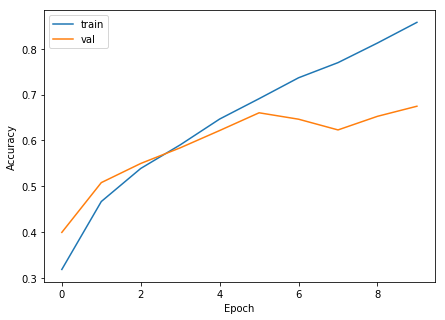

In [9]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(hist_scratch.history['acc'], label='train')
plt.plot(hist_scratch.history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
scores_scratch = myModel_scratch.evaluate(X_test, y_test_hot, verbose=1)

10000/10000 [==============================] - 3s 331us/sample - loss: 1.1324 - acc: 0.6743


In [11]:
print('Test loss    :', scores_scratch[0])
print('Test accuracy: %.2f%%' % (scores_scratch[1]*100))

Test loss    : 1.1323904458999634
Test accuracy: 67.43%


Dapat dilihat, melatih VGG16 pada dataset CIFAR-10 membuat overfit

# Train VGG16 from Scratch with Data Autmentation

In [12]:
model = VGG16(weights=None, include_top=False, input_shape=input_shape, pooling='avg')

x = model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

myModel_aug = Model(inputs=model.input, outputs=predictions, name='VGG Augmented')
myModel_aug.summary()

Model: "VGG Augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)       

Define Data Autmentation schedule

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

Perform Data Augmentation

In [0]:
datagen.fit(X_train)

In [16]:
myModel_aug.compile(loss='categorical_crossentropy',
                        optimizer=opt, metrics=['accuracy'])

hist_aug = myModel_aug.fit_generator(datagen.flow(X_train, y_train_hot,
                                             batch_size=batch_size),
                                epochs=epochs,
                                validation_data=(X_val, y_val_hot))

Epoch 1/10
79/79 [==============================] - 20s 258ms/step - loss: 2.0699 - acc: 0.2057 - val_loss: 1.7988 - val_acc: 0.3098
Epoch 2/10
79/79 [==============================] - 17s 221ms/step - loss: 1.6841 - acc: 0.3553 - val_loss: 1.5535 - val_acc: 0.4093
Epoch 3/10
79/79 [==============================] - 18s 223ms/step - loss: 1.4609 - acc: 0.4535 - val_loss: 1.4236 - val_acc: 0.4748
Epoch 4/10
79/79 [==============================] - 18s 224ms/step - loss: 1.2818 - acc: 0.5276 - val_loss: 1.1768 - val_acc: 0.5725
Epoch 5/10
79/79 [==============================] - 18s 222ms/step - loss: 1.1446 - acc: 0.5829 - val_loss: 1.0989 - val_acc: 0.6061
Epoch 6/10
79/79 [==============================] - 18s 225ms/step - loss: 1.0459 - acc: 0.6205 - val_loss: 1.0738 - val_acc: 0.6181
Epoch 7/10
79/79 [==============================] - 17s 221ms/step - loss: 0.9501 - acc: 0.6579 - val_loss: 0.9854 - val_acc: 0.6529
Epoch 8/10
79/79 [==============================] - 17s 220ms/step - 

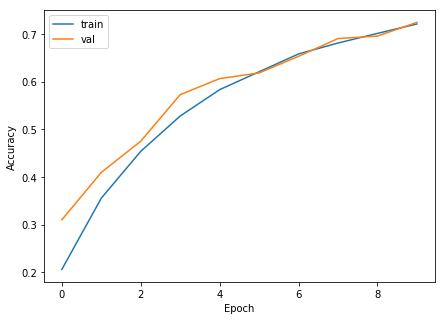

In [17]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(hist_aug.history['acc'], label='train')
plt.plot(hist_aug.history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


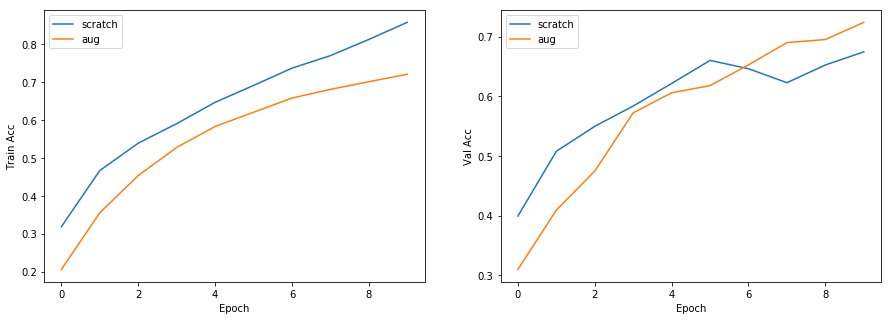

In [18]:
plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 2, 1)
plt.plot(hist_scratch.history['acc'], label='scratch')
plt.plot(hist_aug.history['acc'], label='aug')
plt.xlabel('Epoch')
plt.ylabel('Train Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_scratch.history['val_acc'], label='scratch')
plt.plot(hist_aug.history['val_acc'], label='aug')
plt.xlabel('Epoch')
plt.ylabel('Val Acc')
plt.legend()
plt.show()



In [19]:
scores_aug = myModel_aug.evaluate(X_test, y_test_hot, verbose=1)

10000/10000 [==============================] - 3s 288us/sample - loss: 0.8218 - acc: 0.7164


In [20]:
print('Test loss    :', scores_aug[0])
print('Test accuracy: %.2f%%' % (scores_aug[1]*100))

Test loss    : 0.8217741228103638
Test accuracy: 71.64%


Dapat dilihat, Augmentasi Data dapat memperkecil overfitting

# Train ImageNet-pretrained VGG16

Load model pretrained VGG without the top FC layer,

this code below will download new model without the top FC Layer

In [21]:
model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

x = model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

myModel_imagenet = Model(inputs=model.input, outputs=predictions, name='VGG ImageNet')
myModel_imagenet.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "VGG ImageNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_______________________________________________________

In [0]:
myModel_imagenet.compile(loss='categorical_crossentropy',
                        optimizer=opt, metrics=['accuracy'])

In [24]:
hist_imagenet = myModel_imagenet.fit(X_train, y_train_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val_hot),
                    shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 15s 385us/sample - loss: 2.7003 - acc: 0.1023 - val_loss: 2.3026 - val_acc: 0.1022
Epoch 2/10
40000/40000 [==============================] - 15s 371us/sample - loss: 2.3026 - acc: 0.0994 - val_loss: 2.3026 - val_acc: 0.1022
Epoch 3/10
40000/40000 [==============================] - 15s 375us/sample - loss: 2.3026 - acc: 0.1005 - val_loss: 2.3027 - val_acc: 0.0952
Epoch 4/10
40000/40000 [==============================] - 15s 372us/sample - loss: 2.3026 - acc: 0.1013 - val_loss: 2.3027 - val_acc: 0.0977
Epoch 5/10
40000/40000 [==============================] - 15s 369us/sample - loss: 2.3026 - acc: 0.0995 - val_loss: 2.3027 - val_acc: 0.0952
Epoch 6/10
40000/40000 [==============================] - 15s 368us/sample - loss: 2.3026 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.0952
Epoch 7/10
40000/40000 [==============================] - 15s 368us/sample - loss: 2.3026 - acc: 0.1012 

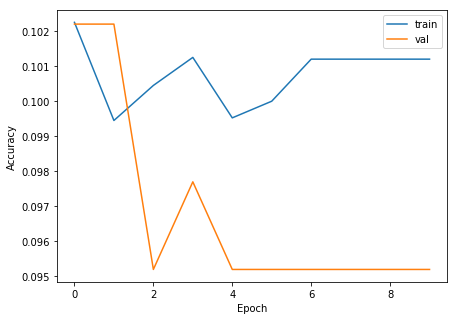

In [25]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(hist_imagenet.history['acc'], label='train')
plt.plot(hist_imagenet.history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


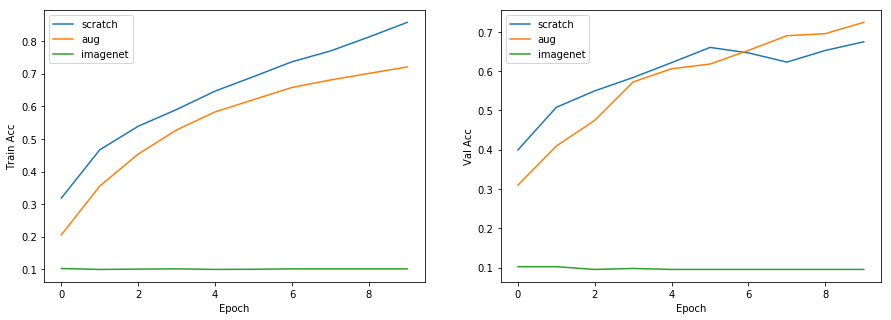

In [26]:
plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 2, 1)
plt.plot(hist_scratch.history['acc'], label='scratch')
plt.plot(hist_aug.history['acc'], label='aug')
plt.plot(hist_imagenet.history['acc'], label='imagenet')
plt.xlabel('Epoch')
plt.ylabel('Train Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_scratch.history['val_acc'], label='scratch')
plt.plot(hist_aug.history['val_acc'], label='aug')
plt.plot(hist_imagenet.history['val_acc'], label='imagenet')
plt.xlabel('Epoch')
plt.ylabel('Val Acc')
plt.legend()
plt.show()



In [27]:
scores_imagenet = myModel_imagenet.evaluate(X_test, y_test_hot, verbose=1)

10000/10000 [==============================] - 3s 294us/sample - loss: 2.3026 - acc: 0.1000


In [28]:
print('Test loss    :', scores_imagenet[0])
print('Test accuracy: %.2f%%' % (scores_imagenet[1]*100))

Test loss    : 2.302595514678955
Test accuracy: 10.00%


Penggunaan Pretrained Model membuat model belajar lebih cepat, dengan masih menjaga dari overfitting meskipun tanpa Augmentasi Data 

# Train FC layer of ImageNet-pretrained VGG16

Load model pretrained VGG without the top FC layer,

In [0]:
model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

Let's freeze the pretrained model so it won't be changed during training

In [0]:
for layer in model.layers:
    layer.trainable = False    

Add new layers

In [31]:
x = model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

myModel_fc = Model(inputs=model.input, outputs=predictions, name='VGG FC')
myModel_fc.summary()

Model: "VGG FC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0    

In [0]:
myModel_fc.compile(loss='categorical_crossentropy',
                        optimizer=opt, metrics=['accuracy'])

In [33]:
hist_fc = myModel_fc.fit(X_train, y_train_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val_hot),
                    shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 161us/sample - loss: 3.4476 - acc: 0.5063 - val_loss: 2.1720 - val_acc: 0.5587
Epoch 2/10
40000/40000 [==============================] - 6s 151us/sample - loss: 1.5302 - acc: 0.6255 - val_loss: 1.8749 - val_acc: 0.5738
Epoch 3/10
40000/40000 [==============================] - 6s 152us/sample - loss: 1.1312 - acc: 0.6795 - val_loss: 1.7963 - val_acc: 0.5805
Epoch 4/10
40000/40000 [==============================] - 6s 152us/sample - loss: 0.9124 - acc: 0.7210 - val_loss: 1.7245 - val_acc: 0.5879
Epoch 5/10
40000/40000 [==============================] - 6s 154us/sample - loss: 0.7669 - acc: 0.7587 - val_loss: 1.6934 - val_acc: 0.5870
Epoch 6/10
40000/40000 [==============================] - 6s 153us/sample - loss: 0.6610 - acc: 0.7879 - val_loss: 1.6759 - val_acc: 0.5950
Epoch 7/10
40000/40000 [==============================] - 6s 153us/sample - loss: 0.5824 - acc: 0.8120 - val_l

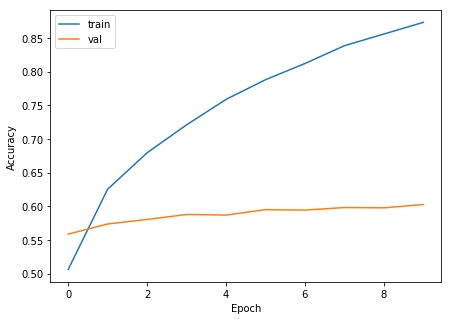

In [34]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(hist_fc.history['acc'], label='train')
plt.plot(hist_fc.history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


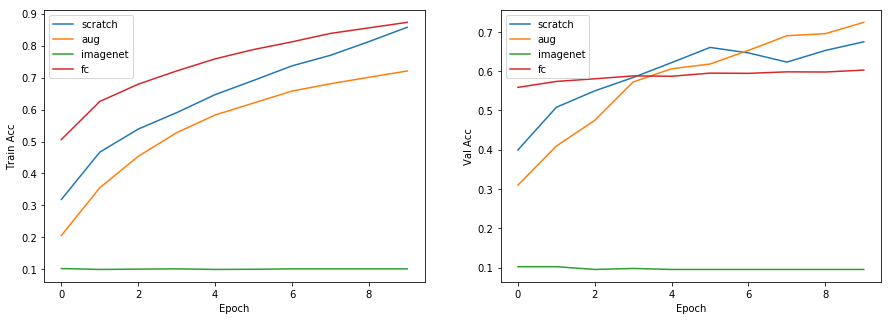

In [35]:
plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 2, 1)
plt.plot(hist_scratch.history['acc'], label='scratch')
plt.plot(hist_aug.history['acc'], label='aug')
plt.plot(hist_imagenet.history['acc'], label='imagenet')
plt.plot(hist_fc.history['acc'], label='fc')
plt.xlabel('Epoch')
plt.ylabel('Train Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_scratch.history['val_acc'], label='scratch')
plt.plot(hist_aug.history['val_acc'], label='aug')
plt.plot(hist_imagenet.history['val_acc'], label='imagenet')
plt.plot(hist_fc.history['val_acc'], label='fc')
plt.xlabel('Epoch')
plt.ylabel('Val Acc')
plt.legend()
plt.show()



In [36]:
scores_fc = myModel_fc.evaluate(X_test, y_test_hot, verbose=1)

10000/10000 [==============================] - 3s 301us/sample - loss: 1.6288 - acc: 0.6032


In [37]:
print('Test loss    :', scores_fc[0])
print('Test accuracy: %.2f%%' % (scores_fc[1]*100))

Test loss    : 1.6288275241851806
Test accuracy: 60.32%


# Train Selected Layers

we can also choose which layer to train and which layer to freeze

First let's see the layer ID and name

In [0]:
model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

x = model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

myModel_selected = Model(inputs=model.input, outputs=predictions, name='VGG Selected')

In [39]:
for i, layer in enumerate(myModel_selected.layers):
    print(i, layer.name)

0 input_5
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_4
20 dense_8
21 dense_9


Choose which to freeze

In [40]:
for layer in myModel_selected.layers[:16]:
    layer.trainable = False
for layer in myModel_selected.layers[16:]:
    layer.trainable = True
    
myModel_selected.summary()

Model: "VGG Selected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [0]:
myModel_selected.compile(loss='categorical_crossentropy',
                        optimizer=opt, metrics=['accuracy'])


In [42]:
hist_selected = myModel_selected.fit(X_train, y_train_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val_hot),
                    shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 8s 191us/sample - loss: 1.8719 - acc: 0.4001 - val_loss: 1.3216 - val_acc: 0.5041
Epoch 2/10
40000/40000 [==============================] - 7s 179us/sample - loss: 1.1529 - acc: 0.5687 - val_loss: 1.1043 - val_acc: 0.5939
Epoch 3/10
40000/40000 [==============================] - 7s 181us/sample - loss: 0.9734 - acc: 0.6464 - val_loss: 0.9706 - val_acc: 0.6580
Epoch 4/10
40000/40000 [==============================] - 7s 182us/sample - loss: 0.8611 - acc: 0.6928 - val_loss: 0.8933 - val_acc: 0.6912
Epoch 5/10
40000/40000 [==============================] - 7s 183us/sample - loss: 0.7770 - acc: 0.7251 - val_loss: 0.9070 - val_acc: 0.6904
Epoch 6/10
40000/40000 [==============================] - 7s 183us/sample - loss: 0.7219 - acc: 0.7469 - val_loss: 0.9094 - val_acc: 0.6916
Epoch 7/10
40000/40000 [==============================] - 7s 183us/sample - loss: 0.6537 - acc: 0.7707 - val_l

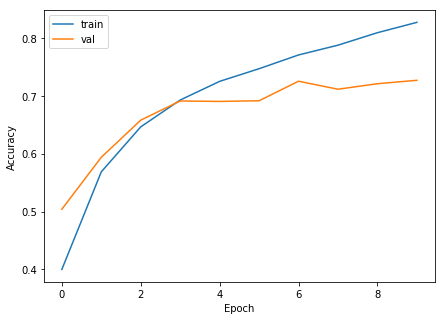

In [43]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(hist_selected.history['acc'], label='train')
plt.plot(hist_selected.history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


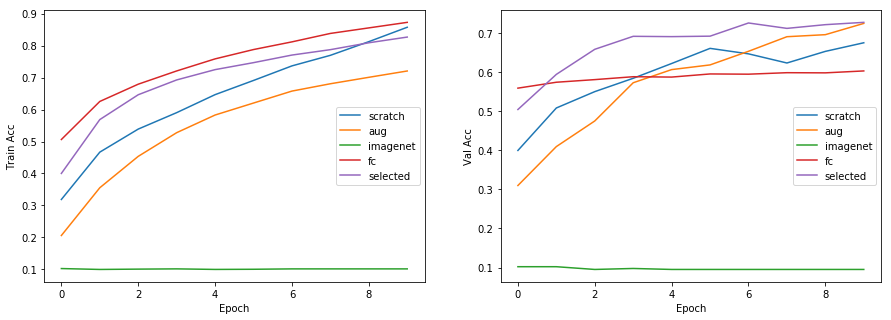

In [44]:
plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 2, 1)
plt.plot(hist_scratch.history['acc'], label='scratch')
plt.plot(hist_aug.history['acc'], label='aug')
plt.plot(hist_imagenet.history['acc'], label='imagenet')
plt.plot(hist_fc.history['acc'], label='fc')
plt.plot(hist_selected.history['acc'], label='selected')
plt.xlabel('Epoch')
plt.ylabel('Train Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_scratch.history['val_acc'], label='scratch')
plt.plot(hist_aug.history['val_acc'], label='aug')
plt.plot(hist_imagenet.history['val_acc'], label='imagenet')
plt.plot(hist_fc.history['val_acc'], label='fc')
plt.plot(hist_selected.history['val_acc'], label='selected')
plt.xlabel('Epoch')
plt.ylabel('Val Acc')
plt.legend()
plt.show()



In [45]:
scores_selected = myModel_selected.evaluate(X_test, y_test_hot, verbose=1)

10000/10000 [==============================] - 3s 296us/sample - loss: 0.8725 - acc: 0.7235


In [46]:
print('Test loss    :', scores_selected[0])
print('Test accuracy: %.2f%%' % (scores_selected[1]*100))

Test loss    : 0.8724772253036499
Test accuracy: 72.35%


# Train Cut Model

In [47]:
model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_6
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_5


In [48]:
# Extract the last layer from third block of vgg16 model
last = model.get_layer('block4_conv3').output

# model baru
x = GlobalAveragePooling2D()(last)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

myModel_cut = Model(inputs=model.input, outputs=predictions, name='VGG Cut')
myModel_cut.summary()

Model: "VGG Cut"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [0]:
myModel_cut.compile(loss='categorical_crossentropy',
                        optimizer=opt, metrics=['accuracy'])


In [50]:
hist_cut = myModel_cut.fit(X_train, y_train_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val_hot),
                    shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 13s 327us/sample - loss: 7.3826 - acc: 0.1332 - val_loss: 2.2512 - val_acc: 0.1449
Epoch 2/10
40000/40000 [==============================] - 13s 313us/sample - loss: 1.9137 - acc: 0.2731 - val_loss: 1.8255 - val_acc: 0.3077
Epoch 3/10
40000/40000 [==============================] - 13s 316us/sample - loss: 1.6315 - acc: 0.3907 - val_loss: 1.5353 - val_acc: 0.4310
Epoch 4/10
40000/40000 [==============================] - 13s 314us/sample - loss: 1.4594 - acc: 0.4570 - val_loss: 1.5322 - val_acc: 0.4366
Epoch 5/10
40000/40000 [==============================] - 13s 315us/sample - loss: 1.3332 - acc: 0.5095 - val_loss: 1.3179 - val_acc: 0.5315
Epoch 6/10
40000/40000 [==============================] - 13s 314us/sample - loss: 1.2160 - acc: 0.5592 - val_loss: 1.1889 - val_acc: 0.5745
Epoch 7/10
40000/40000 [==============================] - 12s 311us/sample - loss: 1.1435 - acc: 0.5908 

In [0]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(hist_cut.history['acc'], label='train')
plt.plot(hist_cut.history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [0]:
plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 2, 1)
plt.plot(hist_scratch.history['acc'], label='scratch')
plt.plot(hist_aug.history['acc'], label='aug')
plt.plot(hist_imagenet.history['acc'], label='imagenet')
plt.plot(hist_fc.history['acc'], label='fc')
plt.plot(hist_selected.history['acc'], label='selected')
plt.plot(hist_cut.history['acc'], label='cut')
plt.xlabel('Epoch')
plt.ylabel('Train Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_scratch.history['val_acc'], label='scratch')
plt.plot(hist_aug.history['val_acc'], label='aug')
plt.plot(hist_imagenet.history['val_acc'], label='imagenet')
plt.plot(hist_fc.history['val_acc'], label='fc')
plt.plot(hist_selected.history['val_acc'], label='selected')
plt.plot(hist_cut.history['val_acc'], label='cut')
plt.xlabel('Epoch')
plt.ylabel('Val Acc')
plt.legend()
plt.show()



In [0]:
scores_cut = myModel_cut.evaluate(X_test, y_test_hot, verbose=1)

In [0]:
print('Test loss    :', scores_cut[0])
print('Test accuracy: %.2f%%' % (scores_cut[1]*100))

# Overall Scores

In [0]:
labels = ['scratch', 'augmented', 'imagenet','fc layer','selected','cut']
y_pos = np.arange(len(labels))
test_scores = [scores_scratch[1],scores_aug[1],scores_imagenet[1],scores_fc[1],scores_selected[1],scores_cut[1]]
val_scores = [hist_scratch.history['val_acc'][-1],hist_aug.history['val_acc'][-1],
              hist_imagenet.history['val_acc'][-1],hist_fc.history['val_acc'][-1],
              hist_selected.history['val_acc'][-1],hist_cut.history['val_acc'][-1]]

plt.bar(y_pos, val_scores, .4, color='g',alpha=0.5, label='val acc')
plt.bar(y_pos+.41, test_scores, .4, color='b',alpha=0.5, label='test acc')
plt.xticks(y_pos+.2, labels)
plt.ylabel('Accuracy')
plt.title('Overall Scores')
plt.ylim((.5,.8))
plt.legend()

plt.show()

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>